## Installing Required Python Packages

Note: run the following cell once. 

In [1]:
# !pip install -r requirements.txt

## Importing essential Python Packages

In [1]:
import os, sys

import numpy as np
from scipy.linalg import eigh
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
import scipy.linalg as sla
import pandas as pd
import numpy as np
from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy import optimize
from scipy.optimize import minimize
from astropy.io import fits
from astropy import wcs
from matplotlib import cm
from matplotlib.colors import LogNorm
from astropy.table import Table

import warnings
warnings.filterwarnings('ignore')


# %matplotlib notebook
# %matplotlib inline
# %matplotlib widget
# %matplotlib ipympl

`pysbf` hold all the auxiliary functions we use in this notebook.

In [6]:
# make sure 

import sys
# path of the pysbf folder
sys.path.insert(0, "/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/")

from pysbf import * #sbfTools

## Object Initialization

In [7]:
## This is the folder that holds recent observations by wfc3 on HST in a SNAP program

# inFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/wfc3-16262/'
galaxy_root = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/'
configFolder = '/media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/notebooks/config/'

As for the PS g-z colors, it looks like we have PS data for about 2/3 of the sample. There are a lot without it. SDSS would be a good alternative.

For the PS reductions, I did the following:

Retrieve a standard 3000 pixel frame with the galaxy at the center in g and z. I renamed them manually for consistency.
I got the exposure time out of the header.

To get the background subtraction right, I first masked off the main galaxy, looked at the residual well away from the galaxy (much larger FOV than WFC3/IR).

I then ran SExtractor to identify stars and other objects, and made a mask automatically. The only elliprof used for PS is to remove the galaxy prior to running SExtractor.

I then edited those masks because PS images typically have lines and edges crossing the brighter galaxies and I didn’t want weird color discontinuities. This is the only manual step, editing the masks to take out lines.

I then generated the g-z color map by subtracting sky, dividing by exposure time, calculating -2.5 log f, and subtracting g-z.

Next step was to use monsta “fluc mask” command to make the elliptical annuli in the same sizes as SBF analysis and write the median and average values to a text file.

In [8]:
# name = "n0679"
# name = "n0439"
name = "u12517"

outFolder = "Outputs_"+name + '/'
createDir(outFolder)

full_name = galaxy_root + name + '/ps/' + name

NR = str(100)


print("Galaxy full name: ", full_name)
print("Output folder: ", outFolder)

Galaxy full name:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/u12517/ps/u12517
Output folder:  Outputs_u12517/


HST file:  /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/u12517/u12517j.fits
RA [deg]:  349.9766666667
Dec [deg]:  43.95766666667


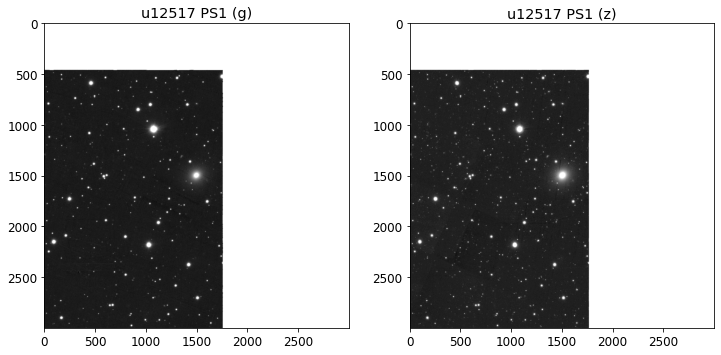

In [9]:
j_fits = galaxy_root + name + '/' + name + 'j.fits'

print("HST file: ", j_fits)

hdul = fits.open(j_fits)
hdr = hdul[0].header     # header

ra  = hdr["RA_TARG"]
dec = hdr["DEC_TARG"]

print("RA [deg]: ",  ra)
print("Dec [deg]: ", dec)

size = 3000   # size in pixels (0.25 arcsec/pixel)

gim = getgrayim(ra,dec,size=size,filter="g")
zim = getgrayim(ra,dec,size=size,filter="z")

pylab.rcParams.update({'font.size':12})
pylab.figure(1,(12,6))

pylab.subplot(121)
pylab.imshow(gim,origin="upper", cmap='gray')
pylab.title(name + ' PS1 (g)')

pylab.subplot(122)
pylab.title(name + ' PS1 (z)')
pylab.imshow(zim,origin="upper", cmap='gray')

### Looking up NED for Galaxtic Extinctions

Here, all we need is to have the coordinates of the galaxy

In [10]:
df_extinction = get_extinction(ra, dec)
df_extinction.set_index("Bandpass", inplace=True)

PS1_rows = [band for band in df_extinction.index.values if "PS1" in band]

df_extinction.loc[PS1_rows]

,Central Wavelength,The Galactic extinction,Refcode of the publications
Bandpass,,,
PS1 g,0.49,0.592,2011ApJ...737..103S
PS1 r,0.62,0.424,2011ApJ...737..103S
PS1 i,0.75,0.314,2011ApJ...737..103S
PS1 z,0.87,0.247,2011ApJ...737..103S
PS1 y,0.97,0.203,2011ApJ...737..103S
PS1 w,0.62,0.437,2011ApJ...737..103S


In [11]:
extinctions = df_extinction["The Galactic extinction"]

gext = extinctions["PS1 g"]
zext = extinctions["PS1 z"]

print("Galactic Extinction (PS1 g): ", gext)
print("Galactic Extinction (PS1 z): ", zext)

Galactic Extinction (PS1 g):  0.592
Galactic Extinction (PS1 z):  0.247


### Downloaidng PS1 files if they don't already exist

In [12]:
## downloading PS1 fits files 
def download_PS1(ra, dec, size, filter='g', format='fits', outFits="PS1.fits"):

    fitsurl = geturl(ra, dec, size=int(size), filters=filter, format=format)
    xcmd("curl '"+fitsurl[0]+"' -o "+outFits, verbose=False)
    print('Downloaded ... ' + outFits)

In [13]:
g_fits = full_name + 'g.fits'
z_fits = full_name + 'z.fits'


# if the original PS1 files do not exist, download them directly and use them
if not os.path.exists(g_fits):
    print('Could not find '+g_fits+'\n Downloading ...')
    g_fits = outFolder+"/"+name+"_back_g.fits"
    download_PS1(ra, dec, size, filter='g', outFits=g_fits)
if not os.path.exists(z_fits):
    print('Could not find '+z_fits+'\n Downloading ...')
    z_fits = outFolder+"/"+name+"_back_z.fits"
    download_PS1(ra, dec, size, filter='z', outFits=z_fits)

print("g-band fits file: " + g_fits)
print("z-band fits file: " + z_fits)

hdul = fits.open(g_fits)
hdr = hdul[0].header     # header
gexp = hdr["EXPTIME"]

hdul = fits.open(z_fits)
hdr = hdul[0].header     # header
zexp = hdr["EXPTIME"]

print("g-band exposure time (sec): " + str(gexp))
print("z-band exposure time (sec): " + str(zexp))

g-band fits file: /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/u12517/ps/u12517g.fits
z-band fits file: /media/Data/Home/PanStarrs/Jan/HI/augment/SBF/codes/u12517/ps/u12517z.fits
g-band exposure time (sec): 602.0
z-band exposure time (sec): 480.0


- Procedure to make masks using SExtractor for 3000x3000 PS images
- be sure to run from a shell where SExtractor runs:
-      `% bash -l`
-      `% source activate sourceextractor`
- usage: `monsta psmakemask.pro n1234 100`
- 27 Sep 2018 J. Jensen
- 18 May 2021 modified paths for with data in ps subdirectories.
- 22 Jun 2021 changed the name, thats all

In [14]:
monsta_script = """
    string name '"""+full_name+"""'
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    !tv 1
    set nr="""+NR+"""/10$nint
    string nr '%i2.0' nr
    cop 3 1
    cop 4 2
    tv 3 zoom=2
    elliprof 3 tv model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    tv 4 zoom=2
    elliprof 4 tv model rmstar x0=1500 y0=1500 r0=7 r1="""+NR+""" nr=nr niter=5
    cop 5 1
    si 5 3
    cop 6 2
    si 6 4
    wd 5 '{name}g.resid'
    wd 6 '{name}z.resid'

    ! run SExtractor
    % sex {name}g.resid -c config/sextractor/psg.inpar -CATALOG_NAME """ +outFolder+"""/psg.cat -CHECKIMAGE_NAME """ +outFolder+"""/psg.obj
    % sex {name}z.resid -c config/sextractor/psz.inpar -CATALOG_NAME """ +outFolder+"""/psz.cat -CHECKIMAGE_NAME """ +outFolder+"""/psz.obj

    rd 7 """+outFolder+"""/psg.obj
    rd 8 """+outFolder+"""/psz.obj
    !tv 7
    !tv 8
    di 7 7
    di 8 8
    mi 8 7
    wd 8 """+outFolder+name+""".PS.mask bitmap
"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

'OK'

Text(0.5, 1.0, 'u12517 Residual (z)')

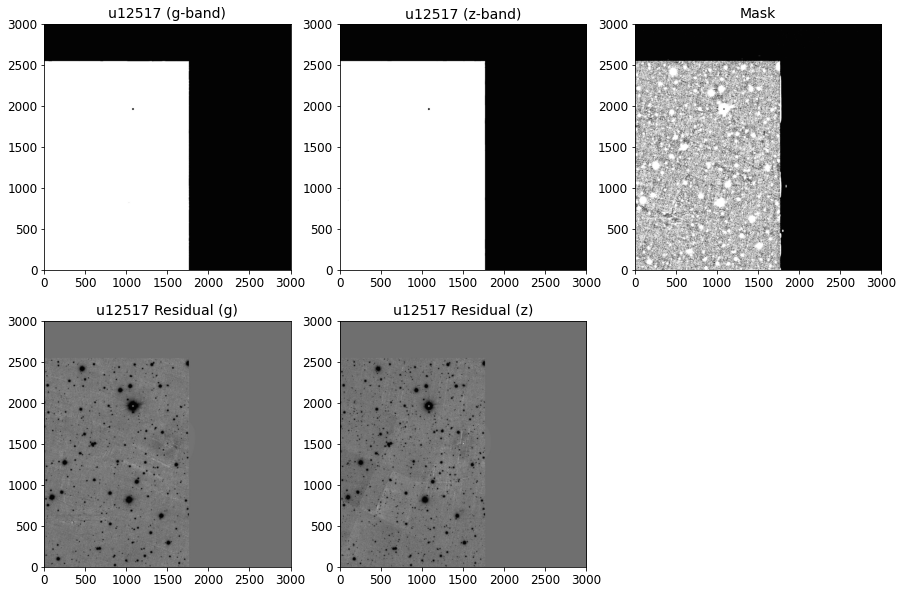

In [15]:
ps_mask = outFolder+name+".PS.mask"


plt.figure(figsize=(15,10))

plt.subplot(231)
ax = plt.gca()
tv(g_fits,ax=ax, options='sqrt')
ax.set_title(name + " (g-band)", fontsize=14)


plt.subplot(232)
ax = plt.gca()
tv(z_fits,ax=ax, options='sqrt')
ax.set_title(name + " (z-band)", fontsize=14)


plt.subplot(233)
ax = plt.gca()
tv(ps_mask,ax=ax)
ax.set_title("Mask", fontsize=14)


plt.subplot(234)
ax = plt.gca()
tv(full_name+"g.resid",ax=ax, options='sqrt')
ax.set_title(name + " Residual (g)", fontsize=14)


plt.subplot(235)
ax = plt.gca()
tv(full_name+"z.resid",ax=ax, options='sqrt')
ax.set_title(name + " Residual (z)", fontsize=14)

- Procedure to compute g-z for PS images
- usage: `monsta gzgcolor.pro <name> <g extinction> <z extinction> <g exposure> <z exposure>` 
-        monsta gzcolor.pro n1234 0.10 0.04 800 900
- 27 Sep 2018 J. Jensen
- 26 Jan 2019 corrected plate scale, computed color clipping +/- 2*sigma
- 18 May 2021 adjusted paths for use in subdirectories

In [16]:
monsta_script = """

    string fname '"""+full_name+"""'
    string name '"""+name+"""'

    ! make the g-z color map and analyze
    rd 1 '"""+g_fits+"""'
    rd 2 '"""+z_fits+"""'
    clip 1 nan=0
    clip 2 nan=0
    dc 1 """+str(gexp)+"""
    dc 2 """+str(zexp)+"""
    cop 3 1
    cop 4 2
    rd 5 ./pssky.mask
    rd 6 """+outFolder+"/"+name+""".PS.mask
    mi 5 6
    mi 3 5
    mi 4 5
    cop 10 4
    ! sky values
    abx 3 all median median={name}sg silent
    abx 4 all median median={name}sz silent
    sc 1 {name}sg
    sc 2 {name}sz
    log 1
    mc 1 -2.5
    sc 1 """+str(gext)+"""
    log 2
    mc 2 -2.5
    sc 2 """+str(zext)+"""
    cop 3 1
    si 3 2
    ! color file - pixel to pixel map
    ! wd 3 {name}gz.clr
    wd 3 """+outFolder+"/"+name+"""gz.clr

    ! rd 1 {name}gz.clr
    ! rd 2 {name}.mask bitmap
    rd 2 """+outFolder+"/"+name+""".PS.mask bitmap
    
    cop 1 3
    mi 1 2
    close 2
    open 2 nr=512 nc=512
    fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    abx 2 all median={name}md medrms={name}rm silent
    typ {name}md,{name}rm
    set {name}mx=2*{name}rm+{name}md
    set {name}mn=-2*{name}rm+{name}md
    typ {name}mn,{name}mx
    clip 1 max={name}mx vmax=0 min={name}mn vmin=0
    close 2
    open 2 nr=512 nc=512
    fluc 2 1 mask x0=1500 y0=1500 r0=15.9 r1=127 a0=0 a1=360 ! cc
    open 3 nr=512 nc=512
    fluc 3 1 mask x0=1500 y0=1500 r0=15.9 r1=31.8 a0=0 a1=360 ! c0
    open 4 nr=512 nc=512
    fluc 4 1 mask x0=1500 y0=1500 r0=31.8 r1=63.5 a0=0 a1=360 ! c1
    open 5 nr=512 nc=512
    fluc 5 1 mask x0=1500 y0=1500 r0=63.5 r1=127 a0=0 a1=360 ! c2
    open 6 nr=512 nc=512
    fluc 6 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=0 a1=90 ! nw
    open 7 nr=512 nc=512
    fluc 7 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=90 a1=180 ! sw
    open 8 nr=512 nc=512
    fluc 8 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=180 a1=270 ! se
    open 9 nr=512 nc=512
    fluc 9 1 mask x0=1500 y0=1500 r0=127 r1=254 a0=270 a1=360 ! ne
    !tv 1 zoom=-2 silent
    !tv 3 zoom=-2 silent
    !tv 4 zoom=-2 silent
    !tv 5 zoom=-2 silent
    !tv 6 zoom=-3 silent
    !tv 7 zoom=-3 silent
    !tv 8 zoom=-3 silent
    !tv 9 zoom=-3 silent
    tv 2 -1 3 silent

    ! medians
    abx 2 all median median={name}cc medrms={name}cr silent
    abx 3 all median median={name}c0 medrms={name}0r silent
    abx 4 all median median={name}c1 medrms={name}1r silent
    abx 5 all median median={name}c2 medrms={name}2r silent
    abx 6 all median median={name}nw medrms={name}nr silent
    abx 7 all median median={name}sw medrms={name}wr silent
    abx 8 all median median={name}se medrms={name}sr silent
    abx 9 all median median={name}ne medrms={name}er silent

    ! doint the same way as we do SBG measurements
    set {name}c5={name}nw+{name}sw+{name}se+{name}ne/4
    printf ''
    printf '{name} median (g-z) extinction corrected'
    typ {name}sg,{name}sz
    printf ''
    typ {name}cc,{name}c0,{name}c1,{name}c2,{name}c5
    printf '{name} (g-z) rms values'
    typ {name}cr,{name}0r,{name}1r,{name}2r,{name}nr

    ! averages
    abx 2 all mean={name}cc rms={name}cr silent
    abx 3 all mean={name}c0 rms={name}0r silent
    abx 4 all mean={name}c1 rms={name}1r silent
    abx 5 all mean={name}c2 rms={name}2r silent
    abx 6 all mean={name}nw rms={name}nr silent
    abx 7 all mean={name}sw rms={name}wr silent
    abx 8 all mean={name}se rms={name}sr silent
    abx 9 all mean={name}ne rms={name}er silent
    set {name}c5={name}nw+{name}sw+{name}se+{name}ne/4
    printf ''
    printf '{name} average (g-z) extinction corrected'
    typ {name}sg, {name}sz
    printf ''
    typ {name}cc,{name}c0,{name}c1,{name}c2,{name}c5
    printf '{name} (g-z) rms values' 
    typ {name}cr,{name}0r,{name}1r,{name}2r,{name}nr

    ! comment this out for interactive use
    ! end

"""

run_monsta(monsta_script, 'monsta.pro', 'monsta.log')

!cat monsta.log

Unity = 0.003     Average radius =    24.3
 U12517MD=   1.3373897075653076     
 U12517RM=   6.6809654235839844E-002
 U12517MN=   1.2037703990936279     
 U12517MX=   1.4710090160369873     
Unity = 0.020     Average radius =    63.1
Unity = 0.003     Average radius =    24.2
Unity = 0.008     Average radius =    47.5
Unity = 0.009     Average radius =    88.3
Unity = 0.002     Average radius =   187.8
Unity = 0.002     Average radius =   177.9
Unity = 0.002     Average radius =   180.4
Unity = 0.002     Average radius =   187.8
 '
 u12517 median (g-z) extinction corrected
 U12517SG=  -5.2392631769180298E-002
 U12517SZ= -0.16769447922706604     
 '
 U12517CC=   1.3375637531280518     
 U12517C0=   1.3403805494308472     
 U12517C1=   1.3320226669311523     
 U12517C2=   1.3421962261199951     
 U12517C5=   1.3449314236640930     
 u12517 (g-z) rms values
 U12517CR=   8.5341930389404297E-002
 U125170R=   6.5824627876281738E-002
 U125171R=   8.6934804916381836E-002
 U125172R=   8.9081406